In [1]:
using Plots
include("DemographicParameters.jl")

Main.DemographicParameters

# Density depnedence models

An importnat component of coupled genetic demographic models is density the density dependence of demographic rates. One simple way to include this process in the model is to have survival to age one depend on the number of age zero individuals. The beverton holt stoch recruit curve is a reasonable funciton form for this relationship. 

$R = \frac{\rho F}{1 + b*F}$

where $R$ is recruitment and $F$ is egg production. This can be dem=cmposed into a denstiy independent and a density dependent step

$J = s*F$

$R = J * \frac{1}{1+bJ/s}$. 

This decomposition is useful for Agent based simulations because F can be quite lrge where as J is typically a much smaller number. 

This functional form implicitly assumes that individuals only compete with others from thier same cohort, which is not neccisarily the case. a more general model of density dependent survival to age one is given by. 

$R = J * \frac{1}{1+b_0J+\sum_A b_a N_a}$

## growth rate when small

An important parameter is the replacement rate when the popualtion is small (density dependence does not apply). here this value is 

$r = s*LEP$

## Equilibrium and stability 

The equilibtium of an age strutured popualtion model with density dependent recruitment given by the previous equation can be found by solving for the stable rate of recruitment 

$R^* =   \frac{r R^*}{1+b_0 r R^*+\sum_{a=1}^{A_{max}} b_a R^* S_a}$.

The rest of the age structure is determined by $R^*$ and the survival rates $N_a = R^* S_a$.

The satailibty of this equilibrium can be found by analyzing the jacobian matrix of the system. 

The jacobian matrix has the form of a lesli matrix with $(1-m_a)$ on the subdiagonal and zeros in all locations but the top row. The vaues in the top row is computed by taking the derivitive of the stock recruit function. 

## $b_a$ terms


I assume the competition terms $b_a$ are given proportional to the $W_a*\delta^a$ where $W_a$ is the weight and $\delta^a$ describes the amount of overlap in resource use betweeen age classes

In [7]:
using Roots
# calcualte equilbrium conditions 
function equilibrium_condition(R_star, r, Sa, b0, ba)
    return R_star - r*R_star/(1+b0*r*R_star + sum(R_star .* Sa .* ba))
end 

function equilibrium(r, survival, b0, ba; min = 10^-5, max = 10^5)
    Sa = vcat([1], broadcast(i -> prod(survival[1:i]), 1:(mod1.Amax-1)))
    R_star = find_zero(x -> equilibrium_condition(x, r, Sa, b0, ba), [min,max])
    return R_star, R_star * Sa
end


## calcualte jacobian

# constants
function c0(Na, r, survival, fecundity, b0, ba)
    Amax = length(fecundity)
    Fa = fecundity
    Sa = vcat([1], broadcast(i -> prod(survival[1:i]), 1:(Amax-1)))
    LEP = sum(Sa.*Fa)
    return r .* Fa ./ LEP
end

function c1(Na, r, survival, fecundity, b0, ba)
    Amax = length(fecundity)
    Fa = fecundity
    Sa = vcat([1], broadcast(i -> prod(survival[1:i]), 1:(Amax-1)))
    LEP = sum(Sa.*Fa)
    return b0*r.*Fa./LEP .+ ba
end

function c2(Na, r, survival, fecundity, b0, ba)
    Amax = length(fecundity)
    Fa = fecundity
    Sa = vcat([1], broadcast(i -> prod(survival[1:i]), 1:(Amax-1)))
    LEP = sum(Sa.*Fa)
    return sum(r.*Fa.*Na./LEP) + sum(ba.*Na) .-r.*Fa.*Na./LEP.- ba.*Na
end

function c3(Na, r, survival, fecundity, b0, ba)
    Amax = length(fecundity)
    Fa = fecundity
    Sa = vcat([1], broadcast(i -> prod(survival[1:i]), 1:(Amax-1)))
    LEP = sum(Sa.*Fa)
    return sum(r.*Fa.*Na./LEP) .-r.*Fa.*Na./LEP
end

function jacobian(r, survival, fecundity, b0, ba)
    Rstar, Na = equilibrium(r, survival, b0, ba)
    c0_ = c0(Na, r, survival, fecundity, b0, ba)
    c1_ = c1(Na, r, survival, fecundity, b0, ba)
    c2_ = c2(Na, r, survival, fecundity, b0, ba)
    c3_ = c3(Na, r, survival, fecundity, b0, ba)
    top_row = c0_ .*(c2_.+1) ./ (c1_ .*Na .+ c2_ .+ 1).^2  .-  c1_.*c3_ ./ (c1_.*Na .+ c2_ .+ 1).^2
    Amax = length(fecundity)
    J = zeros(Amax,Amax)
    
    J[1,:] = top_row
    for i in 1:(Amax-1)
        J[i+1,i] = survival[i]
    end 
    return J
end 

jacobian (generic function with 1 method)

In [8]:
# function for age dependent copmpetitive effects
function ba_(Rstar, r, delta, Wa, survival, fecundity)
    Amax = length(survival)
    Sa = vcat([1], broadcast(i -> prod(survival[1:i]), 1:(Amax-1)))
    b0 = Wa[1]
    ba = vcat(Wa[2:end], [0]) .* broadcast(t -> delta^t, 1:Amax)

    b = (r-1)/(b0*r*Rstar+sum(Rstar*Sa.*ba)) #b0*r*Rstar+


    return b*b0, b*ba #
end 

ba_ (generic function with 1 method)

In [9]:
using Distributions
function update(Na, pars)
    # unpack parameters
    b0, ba, Rstar,  r, survival, fecundity, sigma_R = pars
    LEP = sum(Rstar * vcat([1], broadcast(i -> prod(survival[1:i]), 1:(Amax-1))) .* fecundity)
    ### recruitment 
    # reproduction and density independent mortality 
    J = r*sum(Na .* fecundity) * Rstar/ LEP 

    # density dependent mortality 
    R = J * 1/(1+b0*J + sum(Na.*ba))
    R *=  exp(-0.5*sigma_R^2 + sigma_R*rand(Distributions.Normal(0,1)))
    #### survival and aging
    Na .*= survival
    Na[2:end] = Na[1:(end-1)]
    Na[1] = R
    
    return Na
end 


function update_hatchery(Na, Ht, pars)
    # unpack parameters
    b0, ba, Rstar,  r, survival, fecundity, sigma_R = pars
    LEP = sum(Rstar * vcat([1], broadcast(i -> prod(survival[1:i]), 1:(Amax-1))) .* fecundity)
    ### recruitment 
    # reproduction and density independent mortality 
    J = r*sum(Na .* fecundity) * Rstar/ LEP 

    # density dependent mortality 
    R = J * 1/(1+b0*J + sum(Na.*ba))
    R *=  exp(-0.5*sigma_R^2 + sigma_R*rand(Distributions.Normal(0,1)))
    #### survival and aging
    Na .*= survival
    Na[2:end] = Na[1:(end-1)]
    Na[1] = R + Ht
    
    return Na
end 

update_hatchery (generic function with 1 method)

## equilibrium and stability

In [10]:
mod1 = DemographicParameters.mod_Smyth_2016

# fecundity at age 
Amax = mod1.Amax
survival = mod1.Survival
fecundity = mod1.Fecundity

# recruiotmetn rate + growth rate
Rstar = 60
r = 9.0

# define b paramters 
delta = 0.9
Wa = DemographicParameters.Smyth_16_WAR.(1:150)

b0,ba = ba_(Rstar, r, delta, Wa, survival, fecundity)


J = jacobian(r, mod1.Survival, mod1.Fecundity, b0, ba)
print(" ")

LoadError: UndefVarError: DemographicParameters not defined

In [11]:
p1 = Plots.plot(J[1,:], label = "", xlab = "Age", ylab = "derivitive")
p2 = Plots.plot(ba, label = "", xlab = "Age", ylab = "b")
plot(p1,p2, layout = (2,1))

LoadError: UndefVarError: J not defined

In [12]:
using LinearAlgebra
vals = eigen(J).values
vals[argmax(abs.(vals))]


LoadError: UndefVarError: J not defined

# simulations

In [13]:
Sigma_R = 0.1
pars = (b0, ba, Rstar,  r, survival, fecundity, Sigma_R)
Rstar, Nstar = equilibrium(r, survival, b0, ba)

Amax = 150


Na = zeros(Amax)
Na[1:20] .= 100

T = 6000
N = zeros(T)
R = zeros(T)
for i in 1:T
    Na = update(Na, pars)
    N[i] = sum(Na)
    R[i] = Na[1]
end
print(mean(R))
Plots.plot(N)
Plots.hline!([sum(Nstar)])

LoadError: UndefVarError: b0 not defined

95.15650866011934

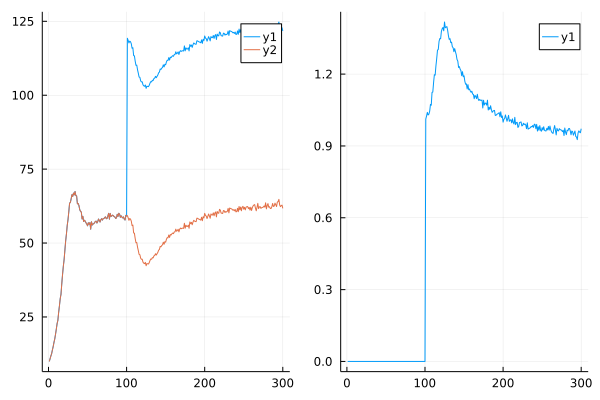

In [81]:
Sigma_R = 0.01

pars = (b0, ba, Rstar,  r, survival, fecundity, Sigma_R)
Rstar, Nstar = equilibrium(r, survival, b0, ba)

Amax = 150


Na = zeros(Amax)
Na[1:20] .= 100
T = 300
N = zeros(T)
R = zeros(T)
Ht = vcat(zeros(100), repeat([Rstar],T))
for i in 1:T
    Na = update_hatchery(Na, Ht[i],pars)
    N[i] = sum(Na)
    R[i] = Na[1]
end
print(mean(R))
p1 = Plots.plot(R)
Plots.plot!(R .- Ht[1:T])
p2 = Plots.plot( Ht[1:T]./(R .- Ht[1:T]) )
plot(p1,p2, layout = (1,2))

# Notes from 4/20

Adding intra cohort dentisity dependence to the model may have importnat implications for the transient genetic response of the population. This is because when intra-cohort competition is added stocking causes an initial decline in natrual recruitment because there is an increase in competition without a compensating increase in spawning stock size to off set the negative effect. this means that the proportion of recruits from hatchery is higher than it would be with out intra cohort competition which should increase the genetic effects.  

# Alternative model structure

there are many possible possible ways to represent density dependence. Here I consider an alternative choice in functional form to see how it effects the dynamics of the population. 

In [104]:
using Roots
# calcualte equilbrium conditions 
function equilibrium_condition_2(R_star, r, Sa, b0, ba)
    return R_star - r*R_star*exp(-b0*r*R_star - sum(R_star.*Sa .* ba))
end 

function equilibrium_2(r, survival, b0, ba; min = 10^-5, max = 10^5)
    Sa = vcat([1], broadcast(i -> prod(survival[1:i]), 1:(mod1.Amax-1)))
    R_star = find_zero(x -> equilibrium_condition_2(x, r, Sa, b0, ba), [min,max])
    return R_star, R_star * Sa
end
    
# function for age dependent copmpetitive effects
function ba_2(Rstar, r, delta, Wa, survival, fecundity)
    Amax = length(survival)
    Sa = vcat([1], broadcast(i -> prod(survival[1:i]), 1:(Amax-1)))
    b0 = Wa[1]
    ba = vcat(Wa[2:end], [0]) .* broadcast(t -> delta^t, 1:Amax)

    b = log(r)/(b0*r*Rstar+sum(Rstar*Sa.*ba)) #b0*r*Rstar+

    return b*b0, b*ba 
end 


ba_2 (generic function with 1 method)

In [105]:
function update_hatchery_2(Na, Ht, pars)
    # unpack parameters
    b0, ba, Rstar,  r, survival, fecundity, sigma_R = pars
    LEP = sum(Rstar * vcat([1], broadcast(i -> prod(survival[1:i]), 1:(Amax-1))) .* fecundity)
    ### recruitment 
    # reproduction and density independent mortality 
    J = r*sum(Na .* fecundity) * Rstar/ LEP 

    # density dependent mortality 
    R = J * exp(-b0*J-sum(Na.*ba))
    R *=  exp(-0.5*sigma_R^2 + sigma_R*rand(Distributions.Normal(0,1)))
    #### survival and aging
    Na .*= survival
    Na[2:end] = Na[1:(end-1)]
    Na[1] = R + Ht
    
    return Na
end

update_hatchery_2 (generic function with 1 method)

In [112]:
mod1 = DemographicParameters.mod_Smyth_2016

# fecundity at age 
Amax = mod1.Amax
survival = mod1.Survival
fecundity = mod1.Fecundity

# recruiotmetn rate + growth rate
Rstar = 60
r = 8.5

# define b paramters 
delta = 0.9
Wa = DemographicParameters.Smyth_16_WAR.(1:150)

b0,ba = ba_2(Rstar, r, delta, Wa, survival, fecundity)
equilibrium_2(r, survival, b0, ba)

(59.999999999999986, [59.999999999999986, 57.59999999999999, 55.295999999999985, 53.08415999999998, 50.96079359999999, 48.92236185599999, 46.965467381759986, 45.08684868648958, 43.28337473903, 41.5520397494688  …  0.19775336211885974, 0.18984322763410535, 0.18224949852874114, 0.17495951858759148, 0.1679611378440878, 0.1612426923303243, 0.1547929846371115, 0.14860126525162703, 0.14265721464156197, 0.13695092605589948])

75.67505773966988

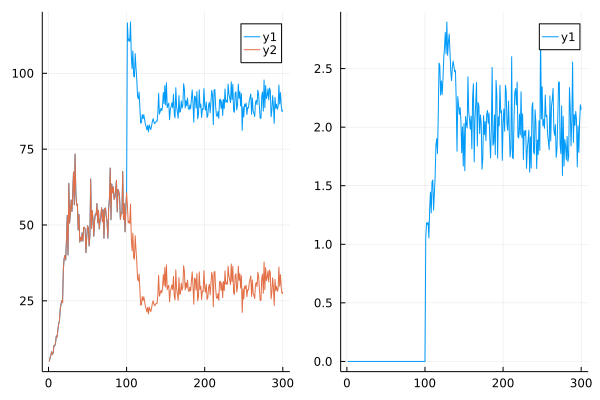

In [207]:
Sigma_R = 0.1

pars = (b0, ba, Rstar,  r, survival, fecundity, Sigma_R)
Rstar, Nstar = equilibrium_2(r, survival, b0, ba)

Amax = 150


Na = zeros(Amax)
Na[1:10] .= 100
T = 300
N = zeros(T)
R = zeros(T)
Ht = vcat(zeros(100), repeat([Rstar],T))
for i in 1:T
    Na = update_hatchery_2(Na, Ht[i],pars)
    N[i] = sum(Na)
    R[i] = Na[1]
end
print(mean(R))
p1 = Plots.plot(R)
Plots.plot!(R .- Ht[1:T])
p2 = Plots.plot( Ht[1:T]./(R .- Ht[1:T]) )
plot(p1,p2, layout = (1,2))

# Derive alternative model

We can derive a differnt phenominological model of inter cohort competition based on some simple assumptions. I essence I assume that during the first year of life indivdiuals in the population experince denstiy-dependent mortality. This depende both on the abundace of other age one individuals are the abundace of older individuals in the popualtion. 

Specifcally, the instantanious natural mortaily rate is a linear function of these abundance

$m_t = c_0 + b_0 N_{0,t} + \sum_{i=0}^A b_i N_i$.

I assume that the abundace of older cohorts remain unchanged during the year.

The abundace of the prerecruts can be expressed as a differential equaiton:

$\dot{N}_0 = \left(c_0 + b_0 N_{0,t} + \sum_{i=0}^A b_i N_i\right)N_0$.

Or writing more simply as 

$\dot{N}_0 = -\left(f(\vec{\textbf{N}}) + b_0 N_{0,t}\right)N_0$.

This can be solved by seperation of variables:

$\frac{dN_0}{dt} = -\left(f(\vec{\textbf{N}}) + b_0 N_{0,t}\right)N_0$

$\int \frac{dN}{-\left(f(\vec{\textbf{N}}) + b_0 N_{0,t}\right)N_0}= \int dt$

$t+c = \frac{1}{f(\vec{\textbf{N}})}log(f(\vec{\textbf{N}})/N_0 + b_0) $

$N_{0,t} = \frac{f(\vec{\textbf{N}})}{e^{f(\vec{\textbf{N}})(t+c)}- b_0}$



$N_{0,0} =  \frac{f(\vec{\textbf{N}})}{e^{f(\vec{\textbf{N}})c}- b_0}$

$c = \frac{1}{f(\vec{\textbf{N}})} log(f(\vec{\textbf{N}})/N_{0,0} + b_0)$

$N_{0,t} = \frac{f(\vec{\textbf{N}})}{e^{f(\vec{\textbf{N}})}e^{log(f(\vec{\textbf{N}})/N_{0,0} + b_0)}-b_0}$

$N_{0,t} = \frac{f(\vec{\textbf{N}})}{e^{f(\vec{\textbf{N}})}(f(\vec{\textbf{N}})/N_{0,0} + b_0 )-b_0} $

$N_{0,t} = \frac{f(\vec{\textbf{N}})e^{-f(\vec{\textbf{N}})}}{(f(\vec{\textbf{N}})/N_{0,0} + b_0 )-b_0 e^{-f(\vec{\textbf{N}})}} $

$N_{0,t} = \frac{N_{0,0}f(\vec{\textbf{N}})e^{-f(\vec{\textbf{N}})}}{f(\vec{\textbf{N}}) + (b_0 -b_0 e^{-f(\vec{\textbf{N}})}) N_{0,0}} $

$N_{0,t} = \frac{N_{0,0}e^{-f(\vec{\textbf{N}})}}{1 + b_0(1 - e^{-f(\vec{\textbf{N}})})f(\vec{\textbf{N}})^{-1} N_{0,0}} $


# Another alterantive model 

I assume that individual in the popualtion depen on a resouce $R$ to grow and that the probability that age zero individual survive the first winter depends on their size / physiological state. 

I assume that individuals from  age class $a$ consume resource $R$ at rate $c_a$. The resouces have chemostat dynamics 

$\frac{dR}{dt} = S - (\rho + \sum_{a=0}^A c_a N_a)R$

The physiological state of the consumer depends on their consumption net of metabolic costs

$\frac{dp}{dt} = c_0*R - m$

For simplicity I assume that metabolic costs and consumption rates do not change with physiolocial state. 

Next I assume that the Resouce cynamcis are fast reletive to the time scale at which growth occurs and can be treated as if it were at equilibrium. 

$R^* \frac{S}{(\rho + \sum_{a=0}^A c_a N_a)}$

This means that the path of an age zero individual physiological state is just a linear function.

$p_t = p_0 + \int_0^t \frac{c_0*S}{(\rho + \sum_{a=0}^A c_a N_a)} - m dt = p_0 +(\frac{c_0*S}{(\rho + \sum_{a=0}^A c_a N_a)} - m) t$. 

Finally we need a functional form that describes the relationship between the pysiological state of the individual and their survival. I will assume this is given by a sigmoidal funciton between size and probaiblity of survival.

$P(survival|p) = exp(-1/p)$


$P(survival|p) = exp\left(\frac{-1}{\left(p_0 +(\frac{c_0*S}{(\rho + \sum_{a=0}^A c_a N_a)} - m) t\right)}\right)$

If we assume inital state and metabolic costs ar reletivly low then the relationship is

$P(survival|p) = exp\left(-\frac{(\rho + \sum_{a=0}^A c_a N_a)}{c_0*S}\right)$

Which is the Ricker model with each age class contributing to density dependence.

Outside of this special case we get a more general versions of the model whcih can be simplified to 

$P(survival|p) = exp\left(\frac{-1}{b_0 + \left(\frac{1}{\rho + \sum_{a=0}^A c_a N_a} \right)}\right)$

Where $b_0$ can take the value of any real number and is an additional control on the shape of the stock recruit curve. negative values increase the strength of the compensatory mechanism while posative values decrease the strength of this mechanism. 

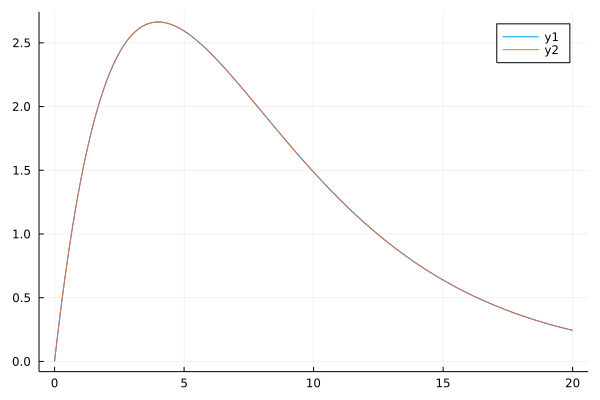

In [28]:
## plot ricker curve and curve with constant
using Plots
function Ricker(N, r, b)
    return r*N*exp(-b*N)
end 

function Ricker_mod(N, r, b, c1, c2)
    return r*N*exp(-1/(1/(c2 + b*N) + c1))
end 

N = 0.0:0.01:20

R = broadcast(N -> Ricker(N, 1.81, 0.25), N)
Rmod = broadcast(N -> Ricker_mod(N, 2, 0.25, 0.0, 0.1), N)
Plots.plot(N,R)
Plots.plot!(N,Rmod)
#Plots.plot!(N,N, ylim = [0,5.0])   

In [70]:
using Roots
using Distributions
include("DemographicParameters.jl")
using Roots
# calcualte equilbrium conditions 
function equilibrium_condition_3(R_star, r, Sa, b0, ba, c_0)
    
    psurvival = exp(  -1/(c_0 + 1/(b0*r*R_star + sum(R_star.*Sa .* ba))))
            
    return R_star - r*R_star*psurvival
end 

function equilibrium_3(r, survival, b0, ba, c_0; min = 10^-13, max = 10^10)
    
    Sa = vcat([1], broadcast(i -> prod(survival[1:i]), 1:(mod1.Amax-1)))
    
    R_star = find_zero(x -> equilibrium_condition_3(x, r, Sa, b0, ba, c_0), [min,max])
    
    return R_star, R_star * Sa
end
    
# function for age dependent copmpetitive effects
function ba_3(Rstar, r, delta, Wa, survival, fecundity, c_0)
    Amax = length(survival)
    Sa = vcat([1], broadcast(i -> prod(survival[1:i]), 1:(Amax-1)))
    b0 = Wa[1]
    ba = vcat(Wa[2:end], [0]) .* broadcast(t -> delta^t, 1:Amax)

    c = log(r)/((1-c_0*log(r))*(b0*r*Rstar+sum(Rstar*Sa.*ba)))

    return c*b0, c*ba 
end 

ba_3 (generic function with 1 method)

In [71]:
function update_hatchery_3(Na, Ht, pars)
    # unpack parameters
    b0, ba, Rstar,  r, survival, fecundity, c_0, sigma_R = pars
    LEP = sum(Rstar * vcat([1], broadcast(i -> prod(survival[1:i]), 1:(Amax-1))) .* fecundity)
    ### recruitment 
    # reproduction and density independent mortality 
    J = r*sum(Na .* fecundity) * Rstar/ LEP 

    # density dependent mortality 
    R = J * exp(  -1/(c_0 + 1/(b0*J + sum(Na .* ba))))
    R *=  exp(-0.5*sigma_R^2 + sigma_R*rand(Distributions.Normal(0,1)))
    #### survival and aging
    Na .*= survival
    Na[2:end] = Na[1:(end-1)]
    Na[1] = R + Ht
    
    return Na
end

update_hatchery_3 (generic function with 1 method)

In [91]:
mod1 = DemographicParameters.mod_Smyth_2016

# fecundity at age 
Amax = mod1.Amax
survival = mod1.Survival
fecundity = mod1.Fecundity

# recruiotmetn rate + growth rate
Rstar = 60
r = 1.5
c_0 = 0.2

# define b paramters 
delta = 0.4
Wa = DemographicParameters.Smyth_16_WAR.(1:150)

b0,ba = ba_3(Rstar, r, delta, Wa, survival, fecundity, c_0)
#equilibrium_3(r, survival, b0, ba, c_0)

(0.0004299484134260681, [0.0013079934464447238, 0.0016792063056110997, 0.0015145039909011866, 0.001125838279280989, 0.0007406629618799919, 0.0004479062516454001, 0.00025469138085012973, 0.00013818094081418202, 7.224734157756605e-5, 3.666282864675308e-5  …  8.730846642301353e-56, 3.4951647548977435e-56, 1.3991591317269335e-56, 5.600865431898278e-57, 2.2419819980393676e-57, 8.974255587022163e-58, 3.5921497952296945e-58, 1.4378066378099762e-58, 5.754888421022089e-59, 0.0])

78.43726211894908

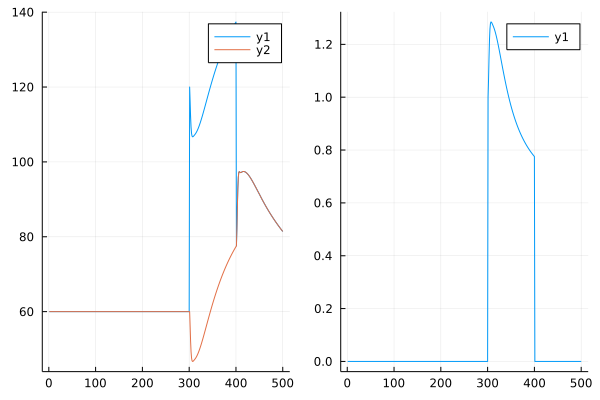

In [92]:
Sigma_R = 0.00

pars = (b0, ba, Rstar,  r, survival, fecundity, c_0, Sigma_R)
#Rstar, Nstar = equilibrium_3(r, survival, b0, ba)

Amax = 150

R, Na = equilibrium_3(r, survival, b0, ba, c_0)
#Na = zeros(Amax)
#Na[1] = 100
T = 500
N = zeros(T)
R = zeros(T)
Ht = vcat(zeros(300), repeat([Rstar],100), zeros(T))
for i in 1:T
    Na = update_hatchery_3(Na, Ht[i],pars)
    N[i] = sum(Na)
    R[i] = Na[1]
end
print(mean(R))
p1 = Plots.plot(R)
Plots.plot!(R .- Ht[1:T])
p2 = Plots.plot( Ht[1:T]./(R .- Ht[1:T]) )
plot(p1,p2, layout = (1,2))